In [ ]:
#Instalar dependencias
!pip install timm faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
# ✅ Importar librerías
import torch
import torchvision.transforms as T
import timm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Maestria/Trimestres/Trimestre 6 Apr-Jun2025/PI"
os.chdir(DATA_PATH)

In [ ]:
model = timm.create_model("vit_small_patch16_224_dino", pretrained=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_small_patch16_224_dino to current vit_small_patch16_224.dino.
  model = create_fn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

#Feature DINO pretrained

In [ ]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_and_preprocess(img_path):
    image = Image.open(img_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Shape: [1, 3, 224, 224]

def extract_feature(model, img_tensor):
    img_tensor = img_tensor.to(device)
    with torch.no_grad():
        feat_map = model.forward_features(img_tensor)
        cls_token = feat_map[:, 0]  # Tomamos solo el token [CLS]
    return cls_token.cpu().squeeze().numpy()

def extract_features_from_folder(folder_path):
    features = []
    image_paths = []
    for fname in os.listdir(folder_path):
        if fname.endswith('.jpg') or fname.endswith('.png'):
            path = os.path.join(folder_path, fname)
            img_tensor = load_and_preprocess(path)
            feat = extract_feature(model, img_tensor)
            features.append(feat)
            image_paths.append(path)
    return np.array(features), image_paths

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Extraer características
feat_full, paths_full = extract_features_from_folder("Chambita_Mantecadas")
feat_sub, paths_sub = extract_features_from_folder("output_image_analysis_bimbo/potentially_good_images")

In [ ]:
print(feat_sub.shape)   # Esperado: (num_imgs, D)
print(feat_full.shape)  # Esperado: (num_imgs, D)


(1935, 384)
(3478, 384)


In [ ]:
# Similaridad
sim_matrix = cosine_similarity(feat_sub, feat_full)



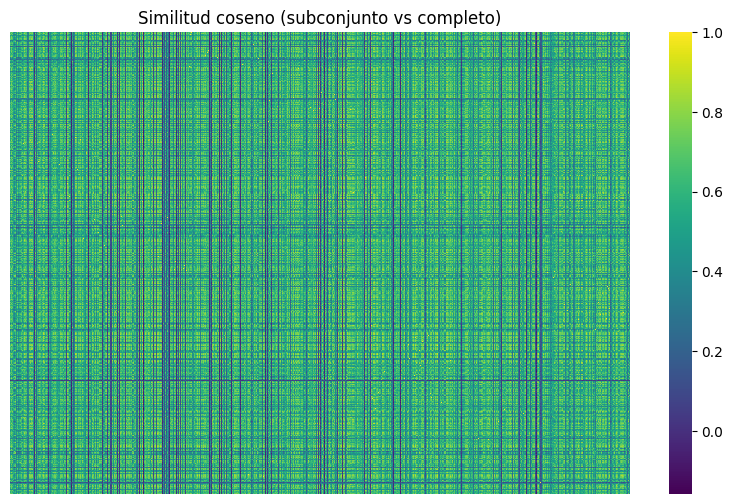

In [ ]:
# Visualización
plt.figure(figsize=(10, 6))
sns.heatmap(sim_matrix, xticklabels=False, yticklabels=False, cmap="viridis")
plt.title("Similitud coseno (subconjunto vs completo)")
plt.show()

In [ ]:
# Tomamos la similitud máxima por cada imagen del conjunto completo
max_sim_per_full_image = sim_matrix.max(axis=0)  # shape: [N_full]

# Clasificamos
threshold = 0.75
results = []
for path, sim in zip(paths_full, max_sim_per_full_image):
    label = 1 if sim >= threshold else 0
    results.append((os.path.basename(path), sim, label))

In [ ]:
for fname, sim, label in results:
    print(f"{fname} -> {sim:.3f} -> clase {label}")


1714428961791_1714428959136-1474.jpg -> 0.881 -> clase 1
1714529546994_1714529545305-1474.jpg -> 0.596 -> clase 0
1714581716951_1714581716844-1474.jpg -> 0.845 -> clase 1
1714594805473_1714594803791-1474.jpg -> 0.849 -> clase 1
1714579719751_1714579719032-1474.jpg -> 1.000 -> clase 1
1714486709115_1714486706877-1474.jpg -> 0.862 -> clase 1
1714448253468_1714448250602-1474.jpg -> 1.000 -> clase 1
1714354878604_1714354877443-1474.jpg -> 0.846 -> clase 1
1714364396041_1714364393706-1474.jpg -> 1.000 -> clase 1
1714344811284_1714341239415-1474.jpg -> 1.000 -> clase 1
1714503771580_1714503769293-1474.jpg -> 1.000 -> clase 1
1714408636373_1714408634363-1474.jpg -> 1.000 -> clase 1
1714450266797_1714450263233-1474.jpg -> 1.000 -> clase 1
1714599024762_1714599024679-1474.jpg -> 1.000 -> clase 1
1714362404105_1714362402063-1474.jpg -> 0.820 -> clase 1
1714499532712_1714499530560-1474.jpg -> 1.000 -> clase 1
1714444227748_1714444223966-1474.jpg -> 0.319 -> clase 0
1714577618298_1714577612012-147

In [ ]:
import pandas as pd

df = pd.DataFrame(results, columns=["imagen", "similitud_max", "clase"])
df.to_csv("clasificacion_similitud_DINO.csv", index=False)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Cargar archivos
manual = pd.read_csv('anotaciones_manual.txt', names=['imagen', 'manual_label'])
preds = pd.read_csv('clasificacion_similitud_DINO.csv')

# Unir por nombre de imagen
df = manual.merge(preds, on='imagen', how='inner')

# Renombrar columna para claridad
df = df.rename(columns={'clase': 'dino_pred'})

# Mostrar primeras filas
df.head(10)

,imagen,manual_label,similitud_max,dino_pred
0,1713824674138_1713824673902-1474.jpg,1,1.000000,1
1,1713824687297_1713824685706-1474.jpg,1,1.000000,1
2,1713824850983_1713824850365-1474.jpg,1,1.000000,1
3,1713824877501_1713821258005-1474.jpg,1,1.000000,1
4,1713824916914_1713824916151-1474.jpg,1,1.000000,1
5,1713825060969_1713825059287-1474.jpg,1,0.861014,1
6,1713825151249_1713825149707-1474.jpg,1,1.000000,1
7,1713825180081_1713825178011-1474.jpg,1,1.000000,1
8,1713825243258_1713825239943-1474.jpg,1,1.000000,1
9,1713825356177_1713825355870-1474.jpg,1,1.000000,1


In [ ]:
# Accuracy
accuracy = accuracy_score(df['manual_label'], df['dino_pred'])
print(f"✅ Accuracy: {accuracy:.3f}")

# Reporte completo
print("\n📊 Classification Report:")
print(classification_report(df['manual_label'], df['dino_pred'], target_names=["No similar", "Similar"]))

# Matriz de confusión
print("\n🔁 Confusion Matrix:")
print(confusion_matrix(df['manual_label'], df['dino_pred']))


✅ Accuracy: 0.888

📊 Classification Report:
              precision    recall  f1-score   support

  No similar       0.58      0.79      0.67       493
     Similar       0.96      0.91      0.93      2984

    accuracy                           0.89      3477
   macro avg       0.77      0.85      0.80      3477
weighted avg       0.91      0.89      0.90      3477


🔁 Confusion Matrix:
[[ 388  105]
 [ 283 2701]]


In [ ]:
# Falsos Positivos: DINO predijo 1, humano dijo 0
fp = df[(df['manual_label'] == 0) & (df['dino_pred'] == 1)]

# Falsos Negativos: DINO predijo 0, humano dijo 1
fn = df[(df['manual_label'] == 1) & (df['dino_pred'] == 0)]

# Ordenar por confianza (similitud)
fp_top10 = fp.sort_values(by='similitud_max', ascending=False).head(10)
fn_top10 = fn.sort_values(by='similitud_max', ascending=True).head(10)  # baja similitud

In [ ]:
print("🟥 Top 10 Falsos Positivos (DINO dijo similar, humano dijo no):")
print(fp_top10[['imagen', 'similitud_max']])

print("\n🟦 Top 10 Falsos Negativos (DINO dijo no similar, humano dijo sí):")
print(fn_top10[['imagen', 'similitud_max']])


🟥 Top 10 Falsos Positivos (DINO dijo similar, humano dijo no):
                                    imagen  similitud_max
706   1713890027532_1713890026196-1474.jpg       1.000001
1037  1713918452042_1713956308608-1474.jpg       1.000001
1442  1713994888451_1713994887362-1474.jpg       1.000001
1623  1714052186791_1714052184270-1474.jpg       1.000001
279   1713838317779_1713838317319-1474.jpg       1.000000
2797  1714602670518_1714602674551-1474.jpg       1.000000
1946  1714144534987_1714144533647-1474.jpg       1.000000
291   1713838633611_1713838632700-1474.jpg       1.000000
3103  1714837600202_1714834013217-1474.jpg       1.000000
1477  1714000652229_1714000649884-1474.jpg       1.000000

🟦 Top 10 Falsos Negativos (DINO dijo no similar, humano dijo sí):
                                    imagen  similitud_max
2806  1714607282589_1714607280428-1474.jpg       0.418730
3388  1715129168169_1715129166642-1474.jpg       0.427956
2990  1714708587506_1714708585886-1474.jpg       0.439141


#Automatic SAM mask generator x DINO

In [ ]:
attn_maps = []

def get_attn_hook(module, input, output):
    if hasattr(module, 'attn_weights'):
        attn_maps.append(module.attn_weights.detach().cpu())

# Paso 3: Reescribir el forward del último bloque de atención
def hook_attention(model):
    def forward_with_attn(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        self.attn_weights = attn  # Esto será leído por el hook
        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj_drop(self.proj(out))

    model.blocks[-1].attn.forward = forward_with_attn.__get__(model.blocks[-1].attn)

hook_attention(model)

In [ ]:
handle = model.blocks[-1].attn.register_forward_hook(get_attn_hook)

# Paso 5: Transformaciones
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


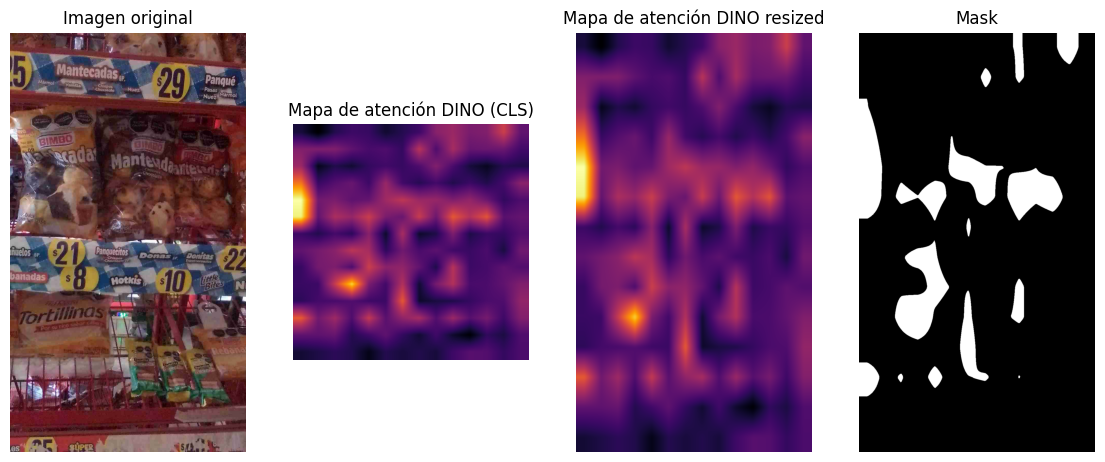

In [ ]:
# Cargar imagen aleatoria
imgs_path = 'output_image_analysis_bimbo/potentially_good_images'
images = [t for t in os.listdir(imgs_path) if os.path.isfile(os.path.join(imgs_path, t))]
img1_file = random.choice(images)
img1 = os.path.join(imgs_path, img1_file)

img_pil = Image.open(img1).convert("RGB")
x = transform(img_pil).unsqueeze(0)

# Ejecutar modelo
attn_maps.clear()
with torch.no_grad():
    _ = model(x)

# Visualizar mapa de atención del token CLS
attn = attn_maps[0]  # (1, heads, tokens, tokens)
cls_attn = attn[0, :, 0, 1:]  # (heads, tokens)
cls_attn = cls_attn.mean(0).reshape(14, 14).numpy()
cls_attn = cv2.resize(cls_attn, (224, 224))

original_size = img_pil.size  # (W, H)

# Redimensionar mapa de atención a tamaño original
cls_attn_resized = cv2.resize(cls_attn, original_size)

# Normalizar a [0, 1]
cls_attn_norm = (cls_attn_resized - cls_attn_resized.min()) / (cls_attn_resized.max() - cls_attn_resized.min() + 1e-8)

plt.figure(figsize=(14, 6))
plt.subplot(1, 4, 1)
plt.imshow(img_pil)
plt.title("Imagen original")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(cls_attn, cmap="inferno")
plt.title("Mapa de atención DINO (CLS)")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(cls_attn_resized, cmap="inferno")
plt.title("Mapa de atención DINO resized")
plt.axis("off")

# Binarizar mascara con umbral normalizado
_, dino_mask = cv2.threshold(cls_attn_norm, 0.4, 1.0, cv2.THRESH_BINARY)
dino_mask = dino_mask.astype(bool)
plt.subplot(1, 4, 4)
plt.imshow(dino_mask, cmap="gray")
plt.title("Mask")
plt.axis("off")
plt.show()

In [ ]:
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-m4lub85i
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-m4lub85i
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=5a2ecda9376f63189c9bc1a27c74ba1b672044b0d2dece047d1b029cd0f4f7eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-p7w1niwg/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-06-16 22:35:47--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.15, 108.157.254.102, 108.157.254.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|1

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
def show_anns(anns, flag=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=flag)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [ ]:
# Imagen original en formato numpy para SAM
img_np = np.array(img_pil)

# Generar todas las máscaras de SAM
sam_masks = mask_generator.generate(img_np)

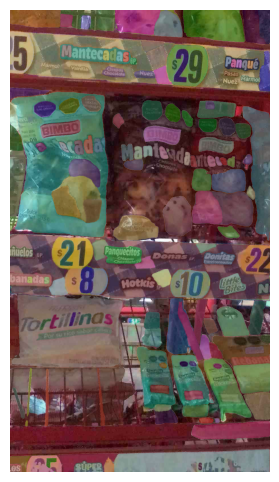

In [ ]:
# show the overlayed masks on image
plt.figure(figsize=(6,6))
plt.imshow(img_np)
show_anns(sam_masks)
plt.axis('off')
plt.show()

In [ ]:
selected_masks = []

for sam_mask in sam_masks:
    seg = sam_mask['segmentation']  # boolean (H, W)

    intersection = np.logical_and(seg, dino_mask)
    #print(f"Número de píxeles en la intersección: {np.sum(intersection)}")
    overlap_ratio = np.sum(intersection) / np.sum(seg)
    #print(f"Overlap ratio: {overlap_ratio}")

    if overlap_ratio > 0.2:
        selected_masks.append(seg)

print(f"Número de máscaras seleccionadas: {len(selected_masks)}")


Número de máscaras seleccionadas: 41


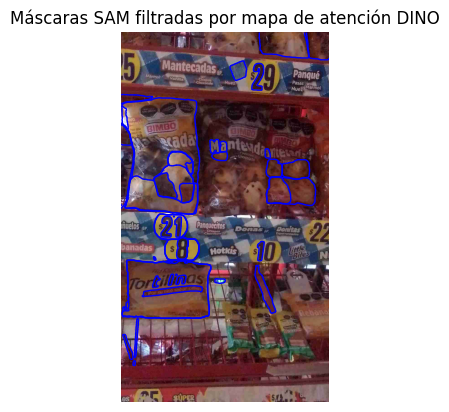

In [ ]:
plt.imshow(img_np)
for m in selected_masks:
    plt.contour(m, colors='blue', linewidths=1)
plt.axis('off')
plt.title("Máscaras SAM filtradas por mapa de atención DINO")
plt.show()
